In [133]:
import pandas as pd
df = pd.read_csv('digit-recognizer/train.csv')

In [141]:
def getimg(i):
    return df.drop('label', axis=1).loc[i].to_numpy().reshape(28, 28)

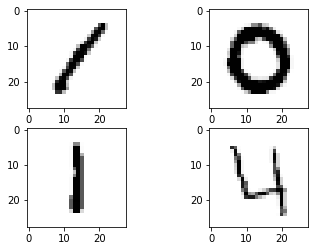

In [142]:
import matplotlib.pyplot as plt
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(getimg(i), cmap='Greys')

In [147]:
import torch
from torch import nn
class ANNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.tanh2 = nn.Tanh()
        
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.elu3 = nn.ELU()
        
        self.fc4 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.tanh2(out)
        out = self.fc3(out)
        out = self.elu3(out)
        out = self.fc4(out)
        return out

input_dim = 28 * 28
hidden_dim = 150
output_dim = 10
model = ANNModel(input_dim, hidden_dim, output_dim)
error = nn.CrossEntropyLoss()
learning_rate = 0.02
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [171]:
from sklearn.model_selection import train_test_split

In [175]:
# prepare data
labels_numpy = df.label.values
features_numpy = df.loc[:, df.columns != 'label'].values

features_train, features_test, labels_train, labels_test = train_test_split(
    features_numpy, labels_numpy, test_size=0.2, random_state=42)

num_train = len(features_train)
labels_train = torch.from_numpy(labels_train)
features_train = torch.from_numpy(features_train) / 255.0

labels_test = torch.from_numpy(labels_test)
features_test = torch.from_numpy(features_test) / 255.0

batch_size = 100
n_iters = 10000
num_epochs = int(n_iters / (num_train / batch_size))

from torch.utils.data import DataLoader

dataset_train = torch.utils.data.TensorDataset(features_train, labels_train)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)

dataset_test = torch.utils.data.TensorDataset(features_test, labels_test)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [176]:
from torch.autograd import Variable
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(dataloader_train):
        features = Variable(images.view(-1, 28 * 28))
        labels = Variable(labels)
        
        optimizer.zero_grad()
        outputs = model(features)
        
        loss = error(outputs, labels)
        loss.backward()
        
        optimizer.step()
        
        count += 1
        if count % 50 == 0:
            correct = 0
            total = 0
            for images, labels in dataloader_test:
                test = Variable(images.view(-1, 28 * 28))
                outputs = model(test) # only forward
                predicted = torch.max(outputs.data, 1)[1]
                total += len(labels)
                correct += (predicted == labels).sum()
            accuracy = 100 * correct / float(total)
                
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if count % 500 == 0:
            print(f"Iteration: {count} Loss: {loss.data} Accuracy {accuracy}")
                

Iteration: 500 Loss: 0.6581493616104126 Accuracy 81.35713958740234
Iteration: 1000 Loss: 0.45472612977027893 Accuracy 87.73809814453125
Iteration: 1500 Loss: 0.21353109180927277 Accuracy 89.75
Iteration: 2000 Loss: 0.29463863372802734 Accuracy 90.91666412353516
Iteration: 2500 Loss: 0.28960373997688293 Accuracy 92.30952453613281
Iteration: 3000 Loss: 0.10757309198379517 Accuracy 93.0952377319336
Iteration: 3500 Loss: 0.230965256690979 Accuracy 93.85713958740234
Iteration: 4000 Loss: 0.057650789618492126 Accuracy 94.22618865966797
Iteration: 4500 Loss: 0.28457018733024597 Accuracy 94.69047546386719
Iteration: 5000 Loss: 0.08765833079814911 Accuracy 95.07142639160156
Iteration: 5500 Loss: 0.16796113550662994 Accuracy 95.14286041259766
Iteration: 6000 Loss: 0.17926426231861115 Accuracy 95.53571319580078
Iteration: 6500 Loss: 0.09392769634723663 Accuracy 95.5952377319336
Iteration: 7000 Loss: 0.1187341958284378 Accuracy 95.92857360839844
Iteration: 7500 Loss: 0.11659551411867142 Accuracy 9

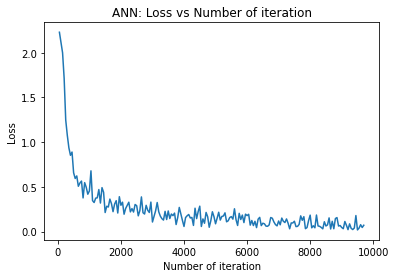

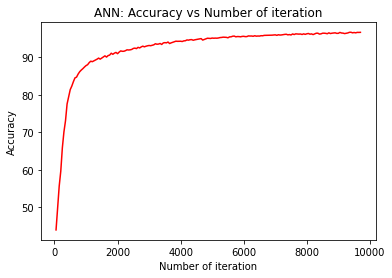

In [177]:
# visualization loss 
plt.plot(iteration_list, loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("ANN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("ANN: Accuracy vs Number of iteration")
plt.show()

In [178]:
test_df = pd.read_csv("digit-recognizer/test.csv")

In [197]:
test_data = test_df.values / 255.0
test_data = torch.from_numpy(test_data).type(torch.FloatTensor)
predictions = []

dataset = torch.utils.data.TensorDataset(test_data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
for images in dataloader:
    images = images[0]
    test = Variable(images.view(-1, 28*28))
    outputs = model(test) # only forward
    predicted = torch.max(outputs.data, 1)[1]
    predictions.extend(predicted)

In [227]:
raw_dict = {}
for i, v in enumerate(predictions):
    raw_dict[i + 1] = v.numpy()

out_df = pd.DataFrame(
    data={
        "ImageId": raw_dict.keys(),
        "Label": raw_dict.values(),
    }
)
out_df.to_csv('/tmp/ans.csv', index=False)